In [1]:
# --- Section 1: Load libraries, env, GCS data ---
from IPython.display import display
import os, pathlib
from dotenv import load_dotenv, dotenv_values
from google.cloud import storage
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf

load_dotenv()

DATA_DIR = "data"
TARGETS = ["circle", "square", "triangle", "star", "vertical_arrows", "axis"]
OTHERS = ["face", "cat", "cloud", "house", "tree"]
CLASS_NAMES = TARGETS + ["other"]
CLASS_TO_ID = {c:i for i,c in enumerate(CLASS_NAMES)}
classes = TARGETS + OTHERS

# GCS client
key_path = dotenv_values(".env")['GOOGLE_APPLICATION_CREDENTIALS']
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path
client = storage.Client()
bucket = client.bucket("doodle-autocomplete")
prefix = "training-data"
os.makedirs(DATA_DIR, exist_ok=True)

for c in classes:
    dst = os.path.join(DATA_DIR, f"{c}.npy")
    if not os.path.exists(dst):
        blob = bucket.blob(f"{prefix}/{c}.npy")
        blob.download_to_filename(dst)
print("Done ✅")

2025-08-28 19:07:26.746110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done ✅


In [2]:
# --- Section 2: Load .npy and build arrays ---
def load_npy(path, limit=None):
    arr = np.load(path)
    if limit is not None:
        arr = arr[:limit]
    return arr.reshape(-1, 28, 28)

def build_arrays(data_dir, per_class=10000, other_total=5000, seed=0):
    rng = np.random.default_rng(seed)
    Xs, ys_class, ys_orient = [], [], []

    for cname in TARGETS:
        path = os.path.join(data_dir, f"{cname}.npy")

        if cname == "vertical_arrows":
            max_samples = 500
            rotations_per_img = 24
            X_base = load_npy(path)
            if len(X_base) > max_samples:
                X_base = rng.choice(X_base, size=max_samples, replace=False)

            Xc, yo = [], []
            for img in X_base:
                angles = np.linspace(0, 360, rotations_per_img, endpoint=False)
                for angle in angles:
                    Xc.append(rotate(img, angle, reshape=False, order=1, mode='constant'))
                    yo.append(angle)

            Xc = np.array(Xc)
            yc = np.full(len(Xc), CLASS_TO_ID[cname], dtype=np.int64)
            yo_rad = np.deg2rad(np.array(yo))
            yo_sin_cos = np.stack([np.sin(yo_rad), np.cos(yo_rad)], axis=1)
            yo = yo_sin_cos

        else:
            Xc = load_npy(path, limit=per_class)
            yc = np.full(len(Xc), CLASS_TO_ID[cname], dtype=np.int64)
            yo = np.full((len(Xc),2), -999.0, dtype=np.float32)  # mask

        Xs.append(Xc)
        ys_class.append(yc)
        ys_orient.append(yo)

    per_other = max(1, other_total // len(OTHERS))
    other_parts = [load_npy(os.path.join(data_dir, f"{c}.npy"), limit=per_other) for c in OTHERS]
    Xo = np.concatenate(other_parts)
    yo = np.full((len(Xo),2), -999.0, dtype=np.float32)
    yc = np.full(len(Xo), CLASS_TO_ID["other"], dtype=np.int64)

    Xs.append(Xo)
    ys_class.append(yc)
    ys_orient.append(yo)

    X = np.concatenate(Xs)[..., None].astype("float32") / 255.0
    y_class = np.concatenate(ys_class)
    y_orient = np.concatenate(ys_orient)

    idx = rng.permutation(len(X))
    return X[idx], y_class[idx], y_orient[idx]

X, y_class, y_orient = build_arrays(DATA_DIR, per_class=5000, other_total=5000)

In [8]:
# --- Section 3: Build model ---
n_classes = len(CLASS_NAMES)
inputs = layers.Input(shape=(28,28,1))
x = layers.Conv2D(16,3,padding="same",activation="relu")(inputs)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32,3,padding="same",activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
shared_dense = layers.Dense(64, activation="relu")(x)

class_output = layers.Dense(n_classes, activation="softmax", name="class_output")(shared_dense)
orient_branch = layers.Dense(32, activation="relu")(shared_dense)
orient_output = layers.Dense(2, activation="linear", name="orient_output")(orient_branch)

model = models.Model(inputs=inputs, outputs=[class_output, orient_output], name="classifier")

def angle_loss(y_true, y_pred):
    mask = tf.reduce_all(tf.not_equal(y_true, -999.0), axis=1)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    def valid_loss():
        y_pred_norm = tf.nn.l2_normalize(y_pred_masked, axis=1)
        cos_diff = tf.reduce_sum(y_true_masked * y_pred_norm, axis=1)
        return tf.reduce_mean(1.0 - cos_diff)
    return tf.cond(tf.size(y_true_masked) > 0, valid_loss, lambda: tf.constant(0.0, dtype=tf.float32))

model.compile(
    optimizer="adam",
    loss={"class_output": "sparse_categorical_crossentropy", "orient_output": angle_loss},
    loss_weights={"class_output": 1.0, "orient_output": 1.0},
    metrics={"class_output": "accuracy", "orient_output": "mae"}
)
model.summary()


Model: "classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 28, 28, 16)           160       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 16)           0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 14, 14, 32)           4640      ['max_pooling2d_2[0][

In [9]:
# --- Section 4: Split data and create arrow_mask ---
arrow_mask = y_class == CLASS_TO_ID["vertical_arrows"]
other_mask = ~arrow_mask

# Vertical arrows (orientation training)
X_arrow = X[arrow_mask]
y_class_arrow = y_class[arrow_mask]
y_orient_arrow = y_orient[arrow_mask]

# Full dataset (classification training)
X_other = X[other_mask]
y_class_other = y_class[other_mask]
y_orient_other = y_orient[other_mask]


In [10]:
# --- Section 5: Train orientation branch on arrows ---
Xtr_arrow, Xva_arrow, y_class_tr_arrow, y_class_va_arrow, y_orient_tr_arrow, y_orient_va_arrow = train_test_split(
    X_arrow, y_class_arrow, y_orient_arrow, test_size=0.1, random_state=42
)

es = EarlyStopping(patience=20, restore_best_weights=True)

# Freeze classification branch
model.get_layer("class_output").trainable = False
model.get_layer("orient_output").trainable = True

# Recompile with only orientation loss
model.compile(
    optimizer="adam",
    loss={"orient_output": angle_loss},
    metrics={"orient_output": "mae"}
)

# Train only on vertical arrows
model.fit(
    Xtr_arrow,
    {"orient_output": y_orient_tr_arrow},
    validation_data=(Xva_arrow, {"orient_output": y_orient_va_arrow}),
    batch_size=64,
    epochs=20,
    callbacks=[es]
)

Epoch 1/20
169/169 [==============================] - 6s 25ms/step - loss: 0.3008 - orient_output_loss: 0.3008 - orient_output_mae: 0.6270 - val_loss: 0.0256 - val_orient_output_loss: 0.0256 - val_orient_output_mae: 0.6187
Epoch 2/20
169/169 [==============================] - 4s 24ms/step - loss: 0.0161 - orient_output_loss: 0.0161 - orient_output_mae: 0.6236 - val_loss: 0.0106 - val_orient_output_loss: 0.0106 - val_orient_output_mae: 0.6201
Epoch 3/20
169/169 [==============================] - 4s 25ms/step - loss: 0.0088 - orient_output_loss: 0.0088 - orient_output_mae: 0.6236 - val_loss: 0.0081 - val_orient_output_loss: 0.0081 - val_orient_output_mae: 0.6192
Epoch 4/20
169/169 [==============================] - 4s 24ms/step - loss: 0.0072 - orient_output_loss: 0.0072 - orient_output_mae: 0.6231 - val_loss: 0.0065 - val_orient_output_loss: 0.0065 - val_orient_output_mae: 0.6187
Epoch 5/20
169/169 [==============================] - 4s 22ms/step - loss: 0.0066 - orient_output_loss: 0.00

In [12]:
# --- Section 6: Train classification branch on all classes ---
Xtr_cls, Xva_cls, y_class_tr_cls, y_class_va_cls, y_orient_tr_cls, y_orient_va_cls = train_test_split(
    X, y_class, y_orient, test_size=0.1, random_state=42
)

es_cls = EarlyStopping(patience=20, restore_best_weights=True)

# Freeze orientation branch
# Freeze only the orientation *output* layer
for layer in model.layers:
    if layer.name == "orient_output":
        layer.trainable = False
    else:
        layer.trainable = True  # keep backbone + class head trainable


# Recompile with only classification loss
model.compile(
    optimizer="adam",
    loss={"class_output": "sparse_categorical_crossentropy"},
    metrics={"class_output": "accuracy"}
)

# Train only on class labels (all classes)
model.fit(
    Xtr_cls,
    {"class_output": y_class_tr_cls},
    validation_data=(Xva_cls, {"class_output": y_class_va_cls}),
    batch_size=64,
    epochs=20,
    callbacks=[es_cls]
)

Epoch 1/20
528/528 [==============================] - 16s 28ms/step - loss: 0.1291 - class_output_loss: 0.1291 - class_output_accuracy: 0.9640 - val_loss: 0.1644 - val_class_output_loss: 0.1644 - val_class_output_accuracy: 0.9526
Epoch 2/20
528/528 [==============================] - 14s 27ms/step - loss: 0.1196 - class_output_loss: 0.1196 - class_output_accuracy: 0.9673 - val_loss: 0.1775 - val_class_output_loss: 0.1775 - val_class_output_accuracy: 0.9518
Epoch 3/20
528/528 [==============================] - 15s 28ms/step - loss: 0.1102 - class_output_loss: 0.1102 - class_output_accuracy: 0.9703 - val_loss: 0.1742 - val_class_output_loss: 0.1742 - val_class_output_accuracy: 0.9534
Epoch 4/20
528/528 [==============================] - 15s 29ms/step - loss: 0.1031 - class_output_loss: 0.1031 - class_output_accuracy: 0.9720 - val_loss: 0.1863 - val_class_output_loss: 0.1863 - val_class_output_accuracy: 0.9512
Epoch 5/20
528/528 [==============================] - 15s 29ms/step - loss: 0.09

In [44]:
# --- Section 7: Prediction utility ---
def predict_and_show_rotated(img_rotated, model, class_names=CLASS_NAMES):
    img_input = img_rotated.astype("float32")/255.0
    img_input = img_input[...,None]
    img_input = np.expand_dims(img_input, axis=0)

    class_pred, orient_pred = model.predict(img_input, verbose=0)
    pred_class_idx = np.argmax(class_pred, axis=1)[0]
    pred_class_name = class_names[pred_class_idx]
    sin_pred, cos_pred = orient_pred[0]

    norm = np.sqrt(sin_pred**2 + cos_pred**2)
    sin_pred /= norm
    cos_pred /= norm
    pred_orientation = np.rad2deg(np.arctan2(sin_pred, cos_pred)) % 360

    plt.imshow(img_rotated, cmap='gray')
    plt.axis('off')
    plt.title(f"{pred_class_name}\nPredicted orientation: {pred_orientation:.1f}°")

    center = (14,14)
    length = 10
    angle_rad = np.deg2rad(pred_orientation)
    dx = length * np.cos(angle_rad)
    dy = -length * np.sin(angle_rad)
    plt.arrow(center[0], center[1], dx, dy, color='red', head_width=2, head_length=3)
    plt.show()

    return pred_class_name, pred_orientation


In [41]:
from scipy.ndimage import rotate

# Load vertical_arrows class
arr = np.load("data/vertical_arrows.npy")  # shape (N, 784)

# Pick the 4th sample (index 3)
img_flat = arr[200]

# Choose a random rotation angle (0–360 degrees)
angle = np.random.uniform(0, 360)

# Rotate the image
img_rotated = rotate(img_flat.reshape(28,28), angle, reshape=False, order=1, mode='constant')

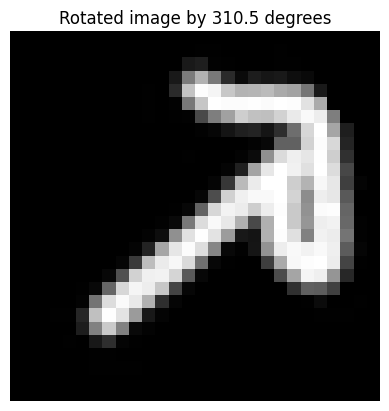

Rotation angle: 310.5032400629324


In [42]:
plt.imshow(img_rotated, cmap='gray')
plt.title(f"Rotated image by {angle:.1f} degrees")
plt.axis('off')
plt.show()

print("Rotation angle:", angle)

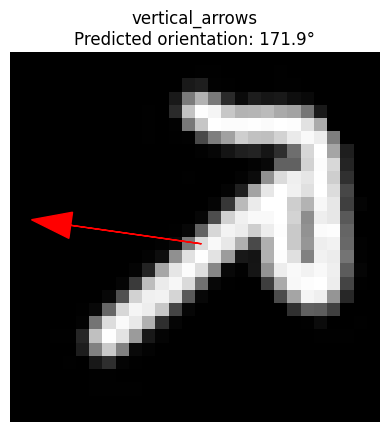

In [43]:
pred_class, pred_orient = predict_and_show_rotated(img_rotated, model)

In [40]:
for i, cname in enumerate(CLASS_NAMES):
    count = np.sum(y_class == i)
    print(f"{cname}: {count} samples")

circle: 5000 samples
square: 5000 samples
triangle: 5000 samples
star: 5000 samples
vertical_arrows: 12000 samples
axis: 511 samples
other: 5000 samples
